# Практическая работа №5
Необходимо на основе результатов, полученных при выполнении Практической работы №4, расширить полученный семантический анализатор естественного языка средствами генерации осмысленного текста только на его основе. Используйте нейросети классов LSTM, а также методы sequence-to-secuence.

In [2]:
import os
import re
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Input
from tensorflow.keras.optimizers import RMSprop

## Параметры

In [3]:
SONGS_NUM = 100
TOPICS_NUM = 8
DISPLAY_NUM = 10

## Загрузка данных

In [4]:
def load_songs(folder_path="data/texts"):
    documents = []
    titles = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                documents.append(content)
                titles.append(filename.replace('.txt', ''))
    
    return documents, titles

songs, song_titles = load_songs("data/texts")
songs = songs[:SONGS_NUM]
song_titles = song_titles[:SONGS_NUM]

print(f"Загружено {len(songs)} песен")

Загружено 100 песен


## Нормализация
Функция *normalize_text* выполняет нормализацию текстов песен, очищая их от лишних символов, пунктуации и стоп слов, а также приводя все слова к нижнему регистру и их базовой форме с помощью лемматизации. За счет этого тексты получаются унифицироваными и готовыми к дальнейшему векторному представлению и семантическому анализу.

In [5]:
def normalize_text(text):
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = text.lower()
    
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    lemmas = [lemmatizer.lemmatize(w) for w in words if w.isalpha() and w not in stop_words]
    return " ".join(lemmas)

normalized_songs = [normalize_text(song) for song in songs]

print("Песни после нормализации:")
for i in range(min(DISPLAY_NUM, len(normalized_songs))):
    print(f'"{song_titles[i]}": {normalized_songs[i][:30]}...')

Песни после нормализации:
"#1": gon na learn got let thing go ...
"America": feel close feel close like wan...
"Amsterdam": sorry brother sorry let well d...
"Bad Liar": look eye tell see perfect para...
"Battle Cry": star visible darkness fear eve...
"Believer": second thing second tell think...
"Birds": season change life make grow d...
"Bleeding Out": day come lost way around seaso...
"Bones": patience waning entertaining p...
"Boomerang": cause bad lettin go lettin go ...


## Расширить полученный семантический анализатор естественного языка для обработки корпуса документов. Используйте нейросети CNN и/или RNN.

In [6]:
nltk.download('vader_lexicon', quiet=True)

def get_text_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    compound_score = scores["compound"]
    if compound_score >= 0.05:
        return "pos"
    elif compound_score <= -0.05:
        return "neg"
    else:
        return "neu"

labels_dict = {
    "neu": "нейтральную",
    "pos": "положительную", 
    "neg": "отрицательную",
}

print("Тональность песен:")
for i in range(min(DISPLAY_NUM, len(normalized_songs))):
    sentiment = get_text_sentiment(normalized_songs[i])
    print(f"Песня {i+1} ({song_titles[i]}) имеет {labels_dict[sentiment]} тональность")

Тональность песен:
Песня 1 (#1) имеет положительную тональность
Песня 2 (America) имеет положительную тональность
Песня 3 (Amsterdam) имеет положительную тональность
Песня 4 (Bad Liar) имеет отрицательную тональность
Песня 5 (Battle Cry) имеет отрицательную тональность
Песня 6 (Believer) имеет отрицательную тональность
Песня 7 (Birds) имеет положительную тональность
Песня 8 (Bleeding Out) имеет отрицательную тональность
Песня 9 (Bones) имеет положительную тональность
Песня 10 (Boomerang) имеет положительную тональность


### Векторизация TF-IDF

In [7]:
vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=2, 
    max_features=1000,
    stop_words="english",
)
tfidf_model = vectorizer.fit_transform(normalized_songs)
feature_names = vectorizer.get_feature_names_out()
print(f"\n10 признаков из матрицы TF-IDF: {', '.join(feature_names[:10])}")


10 признаков из матрицы TF-IDF: afraid, age, ah, ahead, air, alive, allows, alright, answer, anxious


### LSA анализ

In [8]:
def print_heatmap(matrix, titles):
    display_matrix = matrix[:DISPLAY_NUM, :DISPLAY_NUM]
    display_titles = titles[:DISPLAY_NUM]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        display_matrix,
        xticklabels=display_titles,
        yticklabels=display_titles,
        cmap="YlGnBu",
        annot=True,
        fmt=".2f",
        square=True,
    )
    plt.title("Тепловая карта семантической близости песен (LSA)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

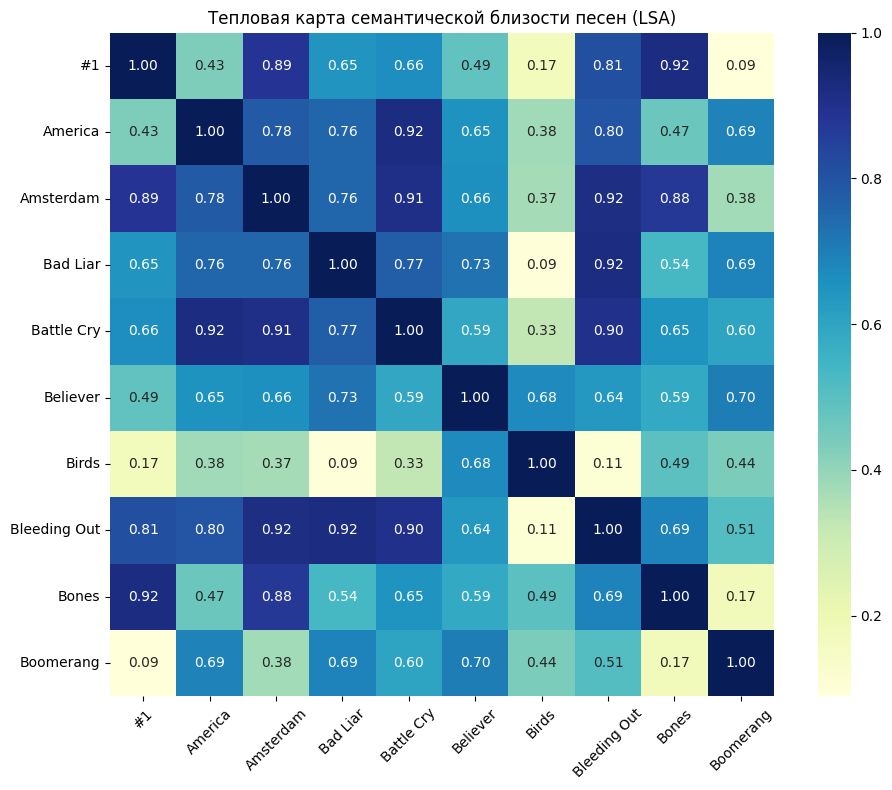

Список самых значимых слов в темах (LSA):
Тема 1: oh, hey, ooh, da, know
Тема 2: da, la, thunder, follow, young
Тема 3: la, hey, gun, okay, love
Тема 4: hey, ooh, da, giving, gun
Тема 5: oh, ready, la, whoa, da
Тема 6: ooh, la, day, fly, night
Тема 7: ah, ooh, yeah, beach, mountain
Тема 8: enemy, everybody, look, want, pray


In [9]:
lsa = TruncatedSVD(n_components=TOPICS_NUM, random_state=0)
lsa_model = lsa.fit_transform(tfidf_model)

similarity_matrix = cosine_similarity(lsa_model)
print_heatmap(similarity_matrix, song_titles)

n_words = 5
print(f"Список самых значимых слов в темах (LSA):")
for i, topic in enumerate(lsa.components_):
    idxs = topic.argsort()[-n_words:][::-1]
    print(f"Тема {i+1}: {', '.join([feature_names[idx] for idx in idxs])}")

### Doc2Vec анализ

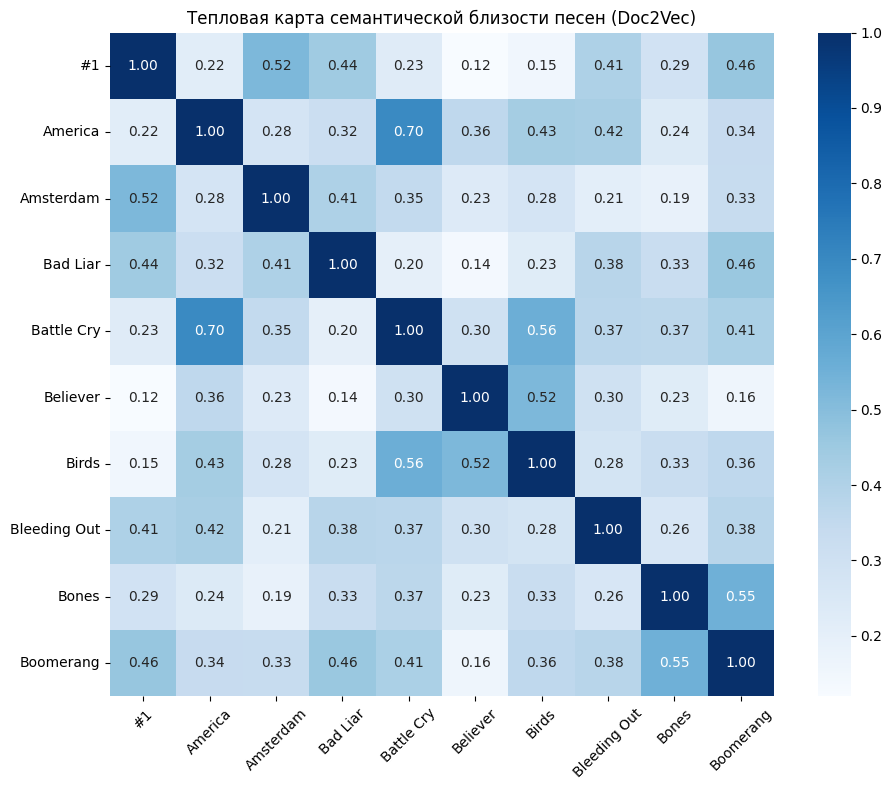

In [10]:
tagged_data = [
    TaggedDocument(words=doc.split(" "), tags=[f"SONG_{i}"])
    for i, doc in enumerate(normalized_songs)
]

doc2vec_model = Doc2Vec(min_count=2, epochs=32, dm=0, workers=4, seed=0)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(
    tagged_data,
    total_examples=doc2vec_model.corpus_count,
    epochs=doc2vec_model.epochs,
)

doc2vec_vectors = np.array([
    doc2vec_model.dv[f"SONG_{i}"] for i in range(len(normalized_songs))
])
doc2vec_similarity = cosine_similarity(doc2vec_vectors)

def print_doc2vec_heatmap(matrix, titles):
    display_matrix = matrix[:DISPLAY_NUM, :DISPLAY_NUM]
    display_titles = titles[:DISPLAY_NUM]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        display_matrix,  
        xticklabels=display_titles,
        yticklabels=display_titles,
        cmap="Blues",
        annot=True,
        fmt=".2f", 
        square=True,
    )
    plt.title("Тепловая карта семантической близости песен (Doc2Vec)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print_doc2vec_heatmap(doc2vec_similarity, song_titles)

### Word2Vec анализ

In [11]:
sentences = [doc.split(" ") for doc in normalized_songs]
word2vec_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1,
    epochs=100,
    seed=0
)

print("\nСемантически похожие слова (Word2Vec):")
if len(word2vec_model.wv.key_to_index) > 0:
    sample_words = list(word2vec_model.wv.key_to_index.keys())[:5]
    for word in sample_words:
        if len(word) > 2:
            try:
                similar_words = word2vec_model.wv.most_similar(word, topn=5)
                print(f"    {word}: {', '.join([s[0] for s in similar_words])}")
            except KeyError:
                print(f"{word}: нет похожих слов")


Семантически похожие слова (Word2Vec):
    hey: paying, west, due, c, bu
    ooh: threw, gate, direction, ragin, silver


### CNN анализ

In [12]:
MAX_VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 200

normalized_all_songs = normalized_songs
sentiments = [get_text_sentiment(t) for t in normalized_all_songs]

le = LabelEncoder()
y = le.fit_transform(sentiments)
num_classes = len(le.classes_)
y = to_categorical(y, num_classes=num_classes)

print(f"Классы тональности: {le.classes_}")
print(f"Распределение: {np.unique(sentiments, return_counts=True)}")

Классы тональности: ['neg' 'neu' 'pos']
Распределение: (array(['neg', 'neu', 'pos'], dtype='<U3'), array([36,  1, 63]))


In [13]:
# Токенизация подготовка
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(normalized_all_songs)
sequences = tokenizer.texts_to_sequences(normalized_all_songs)
word_index = tokenizer.word_index

X = pad_sequences(
    sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post",
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [14]:
embedding_dim = word2vec_model.vector_size
vocab_size = min(len(word_index) + 1, MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

In [15]:
# Создание CNN
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    input_length=MAX_SEQUENCE_LENGTH
))
model.add(Conv1D(64, 5, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

c:\Users\olegs\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
# Обучение
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1,
)

# Оценка
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nТочность определения тональности равна: {test_accuracy:.3f}")

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4667 - loss: 1.0865 - val_accuracy: 0.4500 - val_loss: 0.7084
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5500 - loss: 0.8394 - val_accuracy: 0.7000 - val_loss: 0.6053
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6833 - loss: 0.6365 - val_accuracy: 0.5250 - val_loss: 0.6800
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8500 - loss: 0.5243 - val_accuracy: 0.6750 - val_loss: 0.6362
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8500 - loss: 0.4509 - val_accuracy: 0.7250 - val_loss: 0.6188
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8167 - loss: 0.4588 - val_accuracy: 0.5500 - val_loss: 0.6815
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9167 - loss: 0.4004 - val_accuracy: 0.7500 - val_loss: 0.6215
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9167 - loss: 0.3004 - val_accuracy: 0.7500 - val_loss: 0.6217


## LSTM генерация

In [17]:
raw_songs_text = " ".join(songs)

max_chars_for_training = min(50000, len(raw_songs_text))
raw_songs_text = raw_songs_text[:max_chars_for_training]

print(f"Используется {len(raw_songs_text)} символов из {SONGS_NUM} песен")

Используется 50000 символов из 100 песен


In [18]:
chars = sorted(list(set(raw_songs_text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(raw_songs_text) - maxlen, step):
    sentences.append(raw_songs_text[i:i + maxlen])
    next_chars.append(raw_songs_text[i + maxlen])

print(f"Длина корпуса: {len(raw_songs_text)}")
print(f"Всего символов: {len(chars)}")
print(f"Количество последовательностей для обучения: {len(sentences)}")

Длина корпуса: 50000
Всего символов: 67
Количество последовательностей для обучения: 16654


In [19]:
# Векторизация
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool_)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [20]:
# Создание модели LSTM
model_lstm = Sequential([
    Input(shape=(maxlen, len(chars))),
    LSTM(128),
    Dense(len(chars), activation='softmax')
])

optimizer = RMSprop(learning_rate=0.01)
model_lstm.compile(loss='categorical_crossentropy', 
                   optimizer=optimizer, 
                   metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 67)             │         8,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,995 (425.76 KB)

 Trainable params: 108,995 (425.76 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_lstm.fit(X, y, batch_size=128, epochs=10)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 192ms/step - accuracy: 0.2430 - loss: 2.8299
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.3770 - loss: 2.1451
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.4628 - loss: 1.8365
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.5335 - loss: 1.5978
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.5924 - loss: 1.3929
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.6401 - loss: 1.2196
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.6923 - loss: 1.0656
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.7230 - loss: 0.9422
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.7483 - loss: 0.8489
Epoch 10/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.7737 - loss: 0.7621


In [22]:
# Функция для сэмплирования
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

start_index = len(raw_songs_text) // 3
sentence = raw_songs_text[start_index:start_index + maxlen]
print(f"Начальная последовательность:\n{sentence}")

for diversity in [0.2, 0.8]:
    print(f"\nDiversity: {diversity}")
    generated = ""
    
    for i in range(200):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.0
        
        preds = model_lstm.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        
        sentence = sentence[1:] + next_char
        generated += next_char
    
    print(f"Сгенерировано:\n{generated}...")

Начальная последовательность:
ve never seen this side of you
Oh-oh oh-

Diversity: 0.2
Сгенерировано:
oh oh
Oh, oh oh oh
Oh, the might ease the maght that to change everything the stangt the stang
Love my buttire my side
We are, I down take my sout
I came the that soun that sou' of my sone

'Cause I k...

Diversity: 0.8
Сгенерировано:
now)
'hase the mallin' for it's like arker dream
I wan'd hare my night
Let me the knew you know I'll me the Right what I could mu?
Trybe thase the gigh
It's sarding that I dod, thongin' my sous
It's d...


## SEQ2SEQ

In [50]:
def decode_sequence(input_seq, encoder_model, decoder_model, 
                   target_token_index, reverse_target_char_index,
                   max_decoder_seq_length, num_decoder_tokens):
    
    states_value = encoder_model.predict(input_seq, verbose=0)
    
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.0
    
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        
        if (sampled_char == '\n' or 
            len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        
        states_value = [h, c]
    
    return decoded_sentence

In [51]:
input_texts = []
target_texts = []

num_songs_for_seq2seq = min(SONGS_NUM, len(normalized_songs))

In [52]:
for i, song in enumerate(normalized_songs[:num_songs_for_seq2seq]):
    words = song.split()
    if len(words) >= 10:
        seq_length = min(10, len(words) - 1)
        input_text = " ".join(words[:seq_length])
        target_text = "\t" + " ".join(words[1:seq_length+1]) + "\n"
        input_texts.append(input_text)
        target_texts.append(target_text)

In [53]:
input_characters = set()
target_characters = set()

for text in input_texts:
    for char in text:
        input_characters.add(char)

for text in target_texts:
    for char in text:
        target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [54]:
# Индексы символов
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

# Подготовка данных для encoder и decoder
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32'
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32'
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32'
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    
    if len(input_text) < max_encoder_seq_length:
        encoder_input_data[i, len(input_text):, input_token_index[' ']] = 1.0
    
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    
    if len(target_text) < max_decoder_seq_length:
        decoder_input_data[i, len(target_text):, target_token_index[' ']] = 1.0
        decoder_target_data[i, len(target_text)-1:, target_token_index[' ']] = 1.0

In [55]:
latent_dim = 64

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model_seq2seq = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_seq2seq.compile(optimizer='rmsprop', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

model_seq2seq.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, None, 27)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, None, 29)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 64),      │     23,552 │ input_layer_14[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, None,     │     24,064 │ input_layer_15[0… │
│                     │ 64), (None, 64),  │            │ lstm_5[0][1],     │
│                     │ (None, 64)]       │            │ lstm_5[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, None, 29)  │      1,885 │ lstm_6[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,501 (193.36 KB)

 Trainable params: 49,501 (193.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_seq2seq.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=128,
    epochs=400,
    validation_split=0.2,
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0305 - loss: 3.3780 - val_accuracy: 0.2722 - val_loss: 3.3341
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.2489 - loss: 3.3344 - val_accuracy: 0.3506 - val_loss: 3.2997
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.3486 - loss: 3.2995 - val_accuracy: 0.3785 - val_loss: 3.2641
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.3788 - loss: 3.2636 - val_accuracy: 0.3899 - val_loss: 3.2220
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.3859 - loss: 3.2209 - val_accuracy: 0.3880 - val_loss: 3.1653
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.3867 - loss: 3.1635 - val_accuracy: 0.3867 - val_loss: 3.0771
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.3861 - loss: 3.0740 - val_accuracy: 0.3867 - val_loss: 2.9133
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.3861 - loss: 2.9088 - val_accuracy: 0.3867 - val_

In [57]:
# Создание отдельных моделей для инференса (encoder и decoder)
encoder_inputs = model_seq2seq.input[0]
encoder_outputs, state_h_enc, state_c_enc = model_seq2seq.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model_seq2seq.input[1]
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model_seq2seq.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model_seq2seq.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [58]:
# Функция для декодирования последовательности
def decode_sequence(input_seq):
    
    # Получаем состояния encoder
    states_value = encoder_model.predict(input_seq, verbose=0)
    
    # Создаем пустую целевую последовательность
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Начинаем с символа табуляции
    target_seq[0, 0, target_token_index['\t']] = 1.0
    
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )
        
        # Выбираем символ с наибольшей вероятностью
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        
        # Условия остановки
        if (sampled_char == '\n' or 
            len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        
        # Обновляем целевой sequence
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        
        # Обновляем состояния
        states_value = [h, c]
    
    return decoded_sentence

# Создаем обратные индексы символов
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [59]:
test_indices = [0, 1]
for idx in test_indices:
    if idx < len(input_texts):
        input_seq = encoder_input_data[idx:idx+1]
        decoded_sentence = decode_sequence(input_seq)
        
        print(f"\nПример {idx+1}:")
        print(f"Вход: {input_texts[idx]}")
        print(f"Сгенерировано:\n{decoded_sentence}")


Пример 1:
Вход: gon na learn got let thing go watching candle burn
Сгенерировано:
eee                                                                             

Пример 2:
Вход: feel close feel close like wanted feel close like wanted
Сгенерировано:
eee                                                                             
